In [1]:
import astropy.io.fits as fits
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity
from deep_filaments.metrics.metrics import dice_index
import skimage.morphology as morpho
import torch
from sklearn.metrics import roc_curve, precision_recall_curve, precision_score
from deep_filaments.metrics.quality_measures import compare_segmentation

### Data loading

In [11]:
segmentation_file = "/home/loris/PhD/Dev/Results/nh2_dataset/UNetPP/lr_-3/UNetPP_lr-3_segmentation.fits"
segmentation_map = fits.getdata(segmentation_file)
idx = np.isnan(segmentation_map)
segmentation_map[idx] = 0
header = fits.getheader(segmentation_file)

density_file = "/home/loris/PhD/Dev/Datasets/nh2_dataset/merged/density_merged.fits"
density_image = fits.getdata(density_file)
idx = np.isnan(density_image)
density_image[idx] = 0

groundtruth_file = "/home/loris/PhD/Dev/Datasets/nh2_dataset/merged/spine_merged.fits"
groundtruth_image = fits.getdata(groundtruth_file)
idx = np.isnan(groundtruth_image)
groundtruth_image[idx] = 0

background_file = "/home/loris/PhD/Dev/Datasets/nh2_dataset/merged/background_merged.fits"
background_image = fits.getdata(background_file)
idx = np.isnan(background_image)
background_image[idx] = 0

normed_file = "/home/loris/PhD/Dev/Datasets/nh2_dataset/merged/normed_density_merged.fits"
normed_image = fits.getdata(normed_file)
idx = np.isnan(normed_image)
normed_image[idx] = 0

missing_file = "/home/loris/PhD/Dev/Datasets/nh2_dataset/merged/missing_merged.fits"
missing_image = fits.getdata(missing_file)
idx = np.isnan(missing_image)
missing_image[idx] = 0

torch_background = torch.from_numpy(background_image.astype(np.float64))
torch_groundtruth = torch.from_numpy(groundtruth_image.astype(np.float64))
labels = np.full_like(segmentation_map, -1)
labels[torch_background == 1] = 0
labels[torch_groundtruth == 1] = 1
idx = labels >= 0

# print((background_image * missing_image).sum())
# print((groundtruth_image * missing_image).sum())
# print(((1 - groundtruth_image) * missing_image).sum())

In [14]:
log_image = density_image.copy()
log_image[log_image > 0] = np.log10(log_image[log_image > 0])
log_image -= log_image.min()
log_image /= log_image.max()
n = 8
print(np.mean([structural_similarity(log_image[: , int(i * log_image.shape[1] / n) : int((i + 1) * log_image.shape[1] / n)],
                            normed_image[: , int(i * normed_image.shape[1] / n) : int((i + 1) * normed_image.shape[1] / n)],
                            gaussian_weights=False,
                            use_sample_covariance=False,
                            win_size=31,
                            K1 = 0.00001,
                            K2 = 0.00001,
                            data_range=1)
                            for i in range(n)]))
print(np.mean([structural_similarity(groundtruth_image[: , int(i * groundtruth_image.shape[1] / n) : int((i + 1) * groundtruth_image.shape[1] / n)],
                            normed_image[: , int(i * normed_image.shape[1] / n) : int((i + 1) * normed_image.shape[1] / n)],
                            gaussian_weights=False,
                            use_sample_covariance=False,
                            win_size=31,
                            K1 = 0.00001,
                            K2 = 0.00001,
                            data_range=1)
                            for i in range(n)]))
print(np.mean([structural_similarity(groundtruth_image[: , int(i * groundtruth_image.shape[1] / n) : int((i + 1) * groundtruth_image.shape[1] / n)],
                            log_image[: , int(i * log_image.shape[1] / n) : int((i + 1) * log_image.shape[1] / n)],
                            gaussian_weights=False,
                            use_sample_covariance=False,
                            win_size=31,
                            K1 = 0.00001,
                            K2 = 0.00001,
                            data_range=1)
                            for i in range(n)]))

0.5398993614664357
0.5598195674270645
0.521876245232616


# Segmentation performances and pixel segmetation values

The PR and ROC curve are computed on known groundtruth, not on the whole image:

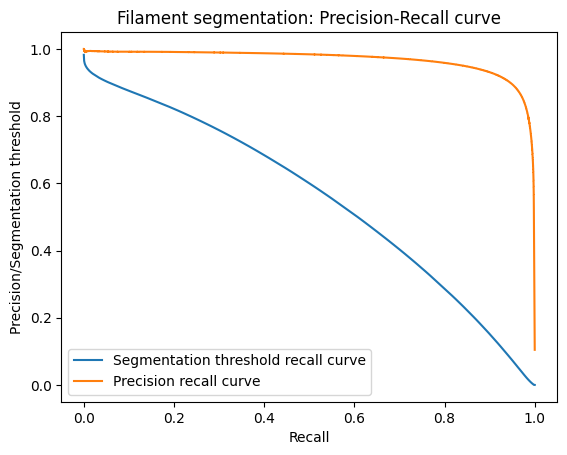

In [10]:
precision, recall, thresholds = precision_recall_curve(labels[idx], segmentation_map[idx])
plt.plot(recall[:-1], thresholds, label="Segmentation threshold recall curve")
plt.plot(recall, precision, label="Precision recall curve")
plt.title("Filament segmentation: Precision-Recall curve")
plt.xlabel("Recall")
plt.ylabel("Precision/Segmentation threshold")
plt.legend()
plt.show()

The PR curve is close to perfect meaning our model distinguish well between class 1 and class 2 and that at any threshold. In other words, most of the class 0 have a very low probability while most of the class 1 have a very high probability.

More information about PR curve in this [link](https://towardsdatascience.com/demystifying-roc-and-precision-recall-curves-d30f3fad2cbf).

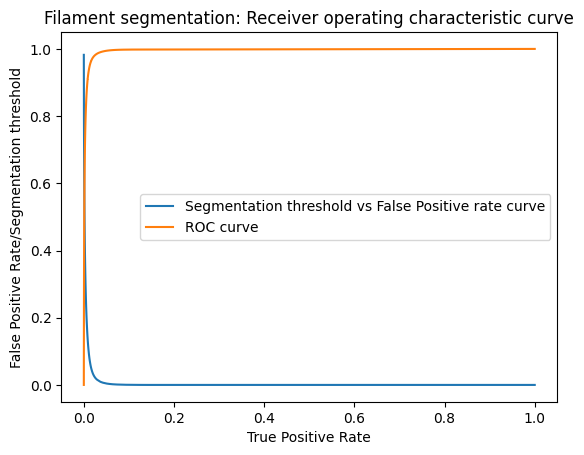

In [15]:
fpr, tpr, thresholds = roc_curve(labels[idx], segmentation_map[idx])
plt.plot(fpr[1:], thresholds[1:], label="Segmentation threshold vs False Positive rate curve")
plt.plot(fpr, tpr, label="ROC curve")
plt.title("Filament segmentation: Receiver operating characteristic curve")
plt.xlabel("True Positive Rate")
plt.ylabel("False Positive Rate/Segmentation threshold")
plt.legend()
plt.show()

The ROC curve is close to perfect meaning our model distinguish well between class 1 and class 2 and that at any threshold. In other words, most of the class 0 have a very low probability while most of the class 1 have a very high probability. This is mostly true but since the dataset is unbalanced (there are more class 0 pixels than class 1, 90% - 10%), so there is a bias.

More information about ROC curve in this [link](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5).

Pixel segmentation values for the segmented images (we excluded missing value: 0) for both known and unknown pixels:

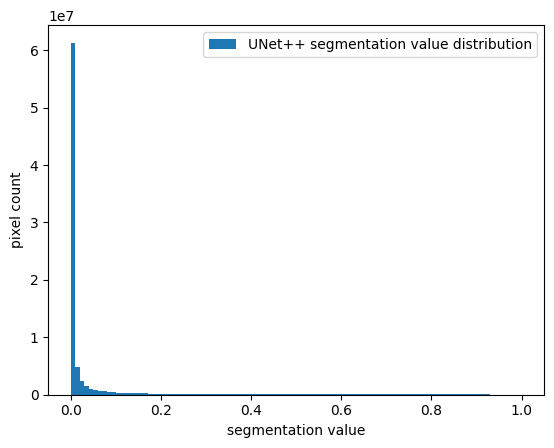

In [9]:
# We remove missing value represented by 0 (nan transformed to 0) to not bias the statistics
flatten_segmentation = segmentation_map[segmentation_map > 0].flatten()

plt.hist(flatten_segmentation, bins=np.linspace(0,1,100), label="UNet++ segmentation value distribution")
plt.xlabel("segmentation value")
plt.ylabel("pixel count")
plt.legend()
plt.show()

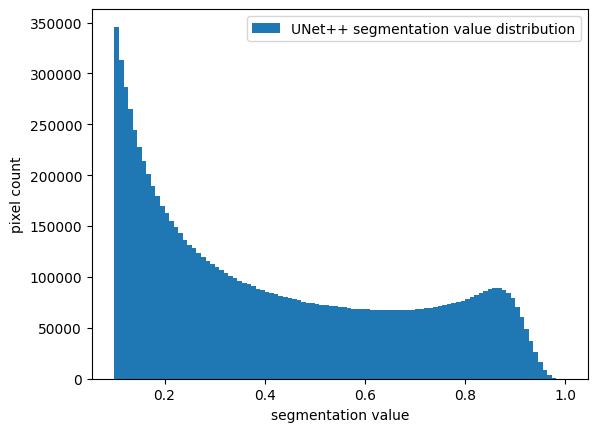

In [27]:
plt.hist(flatten_segmentation, bins=np.linspace(0.1,1,100), label="UNet++ segmentation value distribution")
plt.xlabel("segmentation value")
plt.ylabel("pixel count")
plt.legend()
plt.show()

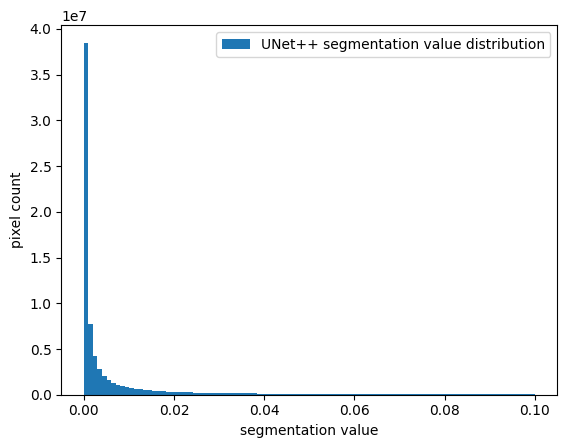

In [28]:
plt.hist(flatten_segmentation, bins=np.linspace(0,0.1,100), label="UNet++ segmentation value distribution")
plt.xlabel("segmentation value")
plt.ylabel("pixel count")
plt.legend()
plt.show()

In [29]:
print("Pourcentage of pixel lower than 0.001:", np.round(len(flatten_segmentation[flatten_segmentation < 0.001]) / len(flatten_segmentation) * 100))
print("Pourcentage of pixel lower than 0.1:", np.round(len(flatten_segmentation[flatten_segmentation < 0.1]) / len(flatten_segmentation) * 100))
print("Pourcentage of pixel lower than 0.5:", np.round(len(flatten_segmentation[flatten_segmentation < 0.5]) / len(flatten_segmentation) * 100))

Pourcentage of pixel lower than 0.001: 46.0
Pourcentage of pixel lower than 0.1: 89.0
Pourcentage of pixel lower than 0.5: 96.0


What we see from the 3 previous histograms is that pixel segmentation values are mainly concentrated towards the very low values (10% of the pixels have a segmentation value higher than 0.1) ***but*** there is a higher density around 0.85 (cf: 2nd histogram).

Pixel segmentation values for the segmented images (we excluded missing value: 0) for only known pixels:

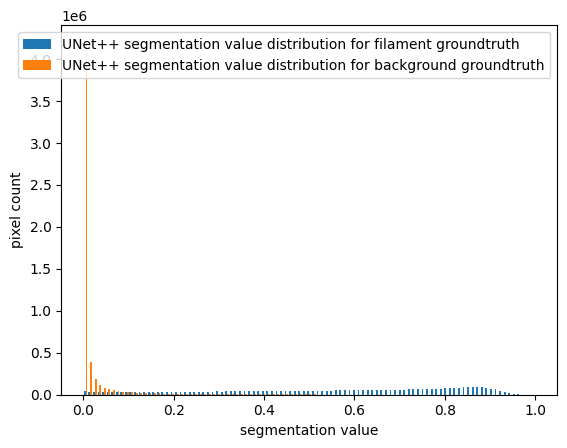

In [3]:
flatten_segmentation = segmentation_map[idx].flatten()
flatten_labels = labels[idx].flatten()
flatten_labels = flatten_labels[flatten_segmentation > 0]
flatten_segmentation = flatten_segmentation[flatten_segmentation > 0]
filament_pixels = flatten_segmentation[flatten_labels == 1]
background_pixels = flatten_segmentation[flatten_labels == 0]
plt.hist([filament_pixels, background_pixels], bins=np.linspace(0,1,100), label=["UNet++ segmentation value distribution for filament groundtruth", "UNet++ segmentation value distribution for background groundtruth"])
plt.xlabel("segmentation value")
plt.ylabel("pixel count")
plt.legend()
plt.show()

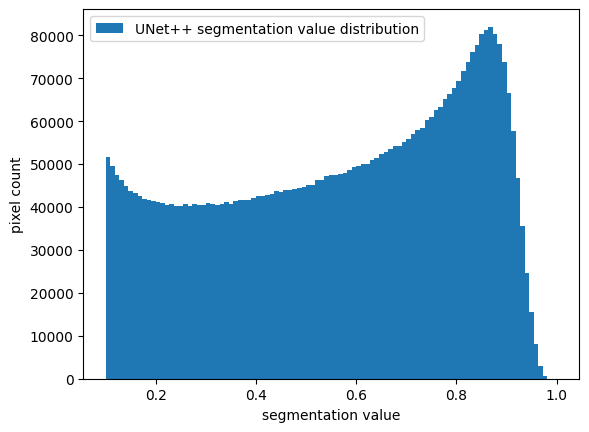

In [8]:
plt.hist(flatten_segmentation, bins=np.linspace(0.1,1,100), label="UNet++ segmentation value distribution")
plt.xlabel("segmentation value")
plt.ylabel("pixel count")
plt.legend()
plt.show()

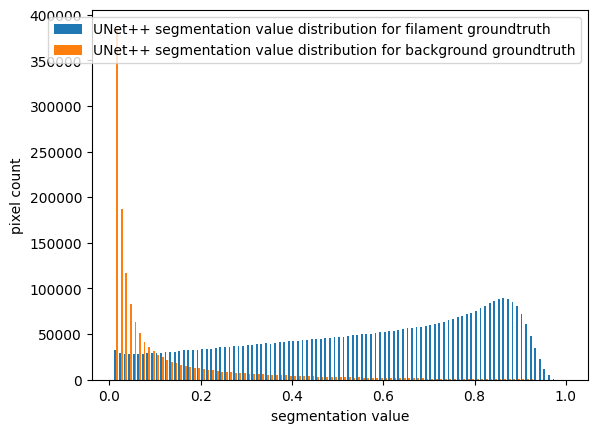

In [34]:
plt.hist([filament_pixels, background_pixels], bins=np.linspace(0.01,1,100), label=["UNet++ segmentation value distribution for filament groundtruth", "UNet++ segmentation value distribution for background groundtruth"])
plt.xlabel("segmentation value")
plt.ylabel("pixel count")
plt.legend()
plt.show()

In [35]:
print("Pourcentage of filament pixels lower than 0.001:", np.round(len(filament_pixels[filament_pixels < 0.001]) / len(filament_pixels) * 100))
print("Pourcentage of filament pixels lower than 0.1:", np.round(len(filament_pixels[filament_pixels < 0.1]) / len(filament_pixels) * 100))
print("Pourcentage of filament pixels lower than 0.5:", np.round(len(filament_pixels[filament_pixels < 0.5]) / len(filament_pixels) * 100))

Pourcentage of filament pixels lower than 0.001: 0.0
Pourcentage of filament pixels lower than 0.1: 6.0
Pourcentage of filament pixels lower than 0.5: 39.0


In [36]:
print("Pourcentage of background pixels lower than 0.001:", np.round(len(background_pixels[background_pixels < 0.001]) / len(background_pixels) * 100))
print("Pourcentage of background pixels lower than 0.1:", np.round(len(background_pixels[background_pixels < 0.1]) / len(background_pixels) * 100))
print("Pourcentage of background pixels lower than 0.5:", np.round(len(background_pixels[background_pixels < 0.5]) / len(background_pixels) * 100))

Pourcentage of filament pixels lower than 0.001: 45.0
Pourcentage of filament pixels lower than 0.1: 92.0
Pourcentage of filament pixels lower than 0.5: 99.0


In [10]:
print(len(flatten_segmentation.flatten()))
print(len(background_pixels) + len(filament_pixels))

83611560
10227955


When we analyse only pixels with groundtruth known and we separate background pixels from filament pixels, we can distinguish two different segmentation value distributions. Background pixels have very low segmentation value and filament pixels have a maximum density around 0.85 but appear to be somewhat dense between 0 and 1. From that observation, we might want to fix the segmentation threshold quite low, around 0.1-0.2 so we get as much filament pixels as possible without getting too much false positive from background pixels with a segmentation value higher than the threshold since we are mainly interested into filament pixels.

Thanks to the ROC and PR curves and the fact that known pixels segmentation value distribution and the overall pixel segmentation value distribution have the same shape, we can expect the same behavior all over the segmentation map.

# Metrics - segmentation thresholds curve

In [25]:
theshold_values = np.linspace(0, 1, 100)
MSSIM_values = np.zeros_like(theshold_values)
DICE_values = np.zeros_like(theshold_values)
Precision_values = np.zeros_like(theshold_values)
F_recovery_values = np.zeros_like(theshold_values)
B_recovery_values = np.zeros_like(theshold_values)

n = 10

for i in range(len(theshold_values)):
    segmentation_binarize_map = segmentation_map.copy()
    segmentation_binarize_map[segmentation_binarize_map < theshold_values[i]] = 0
    segmentation_binarize_map[segmentation_binarize_map >= theshold_values[i]] = 1
    DICE_values[i] = dice_index(segmentation_binarize_map[idx], labels[idx])
    Precision_values[i] = precision_score(segmentation_binarize_map[idx], labels[idx])
    F_recovery_values[i] = compare_segmentation(segmentation_map, groundtruth_image, theshold_values[i])
    B_recovery_values[i] = compare_segmentation(1 - segmentation_map, background_image, theshold_values[i])
    MSSIM_values[i] = np.mean(np.array([structural_similarity(segmentation_binarize_map[: , int(i * segmentation_binarize_map.shape[1] / n) : int((i + 1) * segmentation_binarize_map.shape[1] / n)], 
                                                              density_image[: , int(i * density_image.shape[1] / n) : int((i + 1) * density_image.shape[1] / n)],
                                                              gaussian_weights=True,
                                                              use_sample_covariance=False,
                                                              sigma=5.167,
                                                              K1 = 0.3,
                                                              k2 = 0.3,
                                                              data_range=1,
                                                              ) for i in range(n)]))

DICE_argmax = np.argmax(DICE_values) / len(DICE_values)
MSSIM_argmax = np.argmax(MSSIM_values) / len(MSSIM_values)

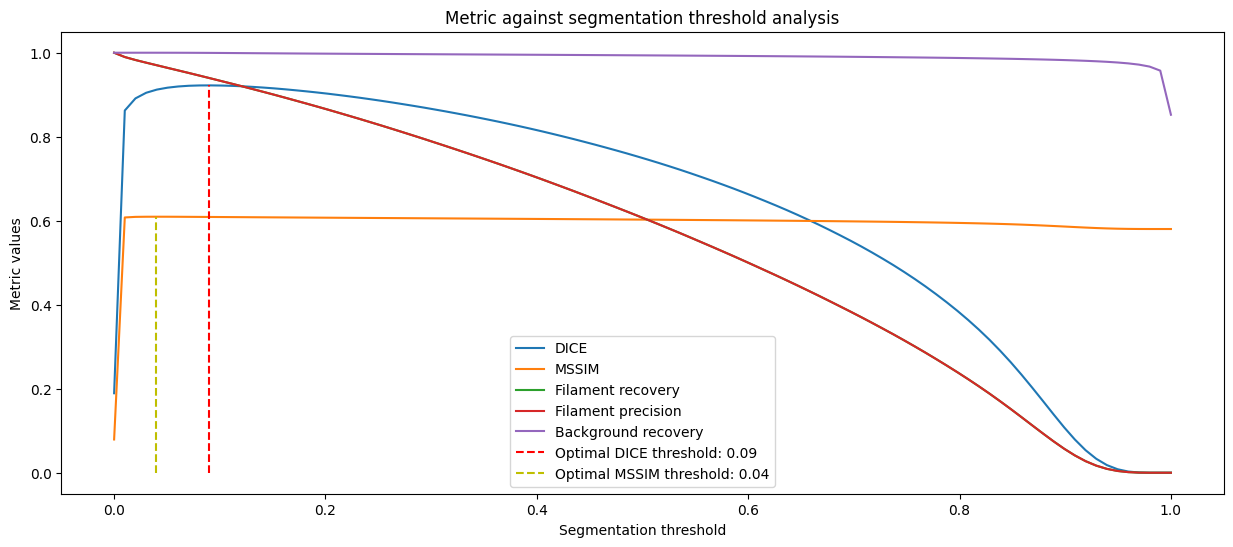

In [26]:
plt.figure(figsize=(15,6))
plt.plot(theshold_values, DICE_values, label="DICE")
plt.plot(theshold_values, MSSIM_values, label="MSSIM")
plt.plot(theshold_values, F_recovery_values, label="Filament recovery")
plt.plot(theshold_values, Precision_values, label="Filament precision")
plt.plot(theshold_values, B_recovery_values, label="Background recovery")
plt.vlines(DICE_argmax, 0, np.max(DICE_values), colors='r', linestyles='dashed', label=f'Optimal DICE threshold: {DICE_argmax}')
plt.vlines(MSSIM_argmax, 0, np.max(MSSIM_values), colors='y', linestyles='dashed', label=f'Optimal MSSIM threshold: {MSSIM_argmax}')
plt.xlabel('Segmentation threshold')
plt.ylabel('Metric values')
plt.title('Metric against segmentation threshold analysis')
plt.legend()
plt.show()

The analysis of different metrics against the threshold value taken confirm what we conjectured from pixel segmentation value distributions:
- Filament recovery: The lower we go, the better in a linear way because the filament segmentation value distribution is roughly a uniform distribution between 0 and 1.
- Background recovery: We can see that it quickly reach 1 meaning fixing a segmentation threshold higher than 0.2 has no good effect on background recovery.
- DICE: The DICE correspond (very roughly) to a weighted sum between the filament and background recovery taking into account the unbalanced aspect in the data. To determined a segmentation threshold, we should look very carefully to this metric.
- MSSIM: The difference of value from one segmentation threshold to the other should be very small but still significant according to this [article](https://iopscience.iop.org/article/10.3847/2041-8213/aa6e50). But a optimal threshold of 0.01 doesn't look so right. A more detailed study of the MSSIM is conducted in the following cells.  

# MSSIM: a metric to remove non existant filaments

MSSIM ref: https://scikit-image.org/docs/stable/api/skimage.metrics.html#skimage.metrics.structural_similarity

We compute the MSSIM of the segmentation image:

raw image MSSIM: 0.09808991397557718


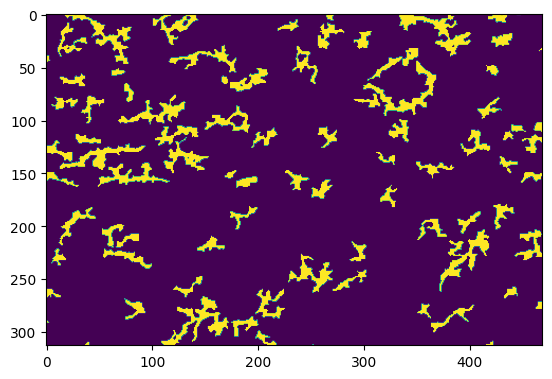

In [2]:
segmentation_file = "../../data_exploration/data/SEDIGISM/16/NH2_16_UNetPP.fits"
segmentation_map = fits.getdata(segmentation_file)
idx = np.isnan(segmentation_map)
segmentation_map[idx] = 0
header = fits.getheader(segmentation_file)

normed_file = "../../data_exploration/data/SEDIGISM/16/NH2_16_normed.fits"
normed_image = fits.getdata(normed_file)
idx = np.isnan(normed_image)
normed_image[idx] = 0

sigma = 5
C1 = 0.0001
data_range = 1

K1 = np.sqrt(C1 / data_range)

plt.imshow(segmentation_map)
print("raw image MSSIM:", structural_similarity(segmentation_map,
                                                normed_image, 
                                                gaussian_weights=True,
                                                use_sample_covariance=False,
                                                sigma=sigma,
                                                K1 = K1,
                                                K2 = K1,
                                                data_range=data_range))

This is the reference image we will use to compute the MSSIM. It is the normalized density image:

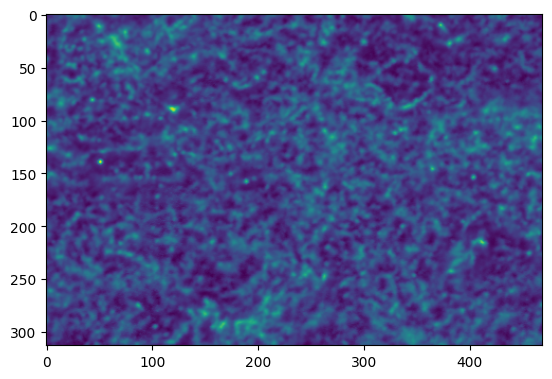

In [4]:
plt.imshow(normed_image)

We add some noise to the segmentation image:

Adversarial image MSSIM: 0.10043847354936969


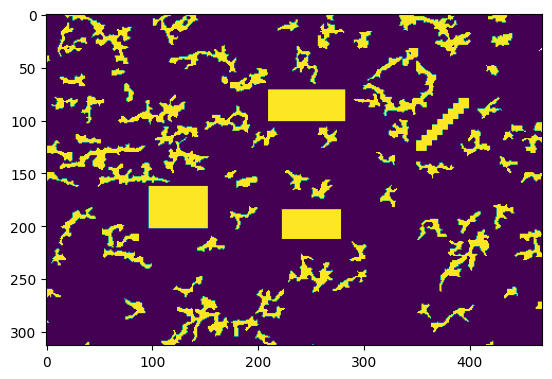

In [82]:
segmentation_map[185 : 185 + 28, 223 : 233 + 46] = 1
segmentation_map[163 : 323 + 40, 97 : 97 + 56] = 1
segmentation_map[72 : 72 + 30, 210 : 210 + 73] = 1
segmentation_map[120 : 120 + 10, 350 : 350 + 10] = 1
segmentation_map[115 : 115 + 10, 355 : 355 + 10] = 1
segmentation_map[110 : 110 + 10, 360 : 360 + 10] = 1
segmentation_map[105 : 105 + 10, 365 : 365 + 10] = 1
segmentation_map[100 : 100 + 10, 370 : 370 + 10] = 1
segmentation_map[95 : 95 + 10, 375 : 375 + 10] = 1
segmentation_map[90 : 90 + 10, 380 : 380 + 10] = 1
segmentation_map[85 : 85 + 10, 385 : 385 + 10] = 1
segmentation_map[80 : 80 + 10, 390 : 390 + 10] = 1

filaments = morpho.label(segmentation_map, connectivity=2)
fits.writeto("../../data_exploration/data/SEDIGISM/16/NH2_16_mssim_issues.fits", data=filaments, header=header, overwrite=True)
mssim = structural_similarity(segmentation_map,
                                normed_image, 
                                gaussian_weights=True,
                                use_sample_covariance=False,
                                sigma=sigma,
                                K1 = K1,
                                K2 = K1,
                                data_range=data_range)
plt.imshow(segmentation_map)
print("Adversarial image MSSIM:", mssim)

When we compute the MSSIM on the noisy image, we can notice the MSSIM increase, meaning the image is closer to the reference image than the segmentation one (without no noise). This meaning, according to this [article](https://iopscience.iop.org/article/10.3847/2041-8213/aa6e50) that it is a better filament segmentation.

I tried to generate a random image and to compute the MSSIM to test the limite of MSSIM. Turns out I couldn't find any random images generated by normal or uniformed distribution with a better MSSIM than the segmentation image.

MSSIM of a random noise image: 0.007161152246806969


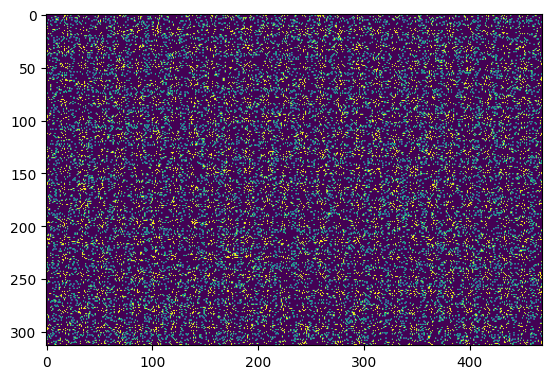

In [83]:
random_image = np.random.normal(0, 1, size=segmentation_map.shape)
random_image[random_image < 1.1] = 0
random_image[random_image >= 1.1] = 1
mssim_random = structural_similarity(random_image, normed_image, gaussian_weights=True, use_sample_covariance=False, sigma=1.5, data_range=np.max(normed_image))
plt.imshow(random_image)
print("MSSIM of a random noise image:", mssim_random)
fits.writeto("../../data_exploration/data/SEDIGISM/16/NH2_16_random.fits", data=random_image, header=header, overwrite=True)

This is the code to go through every structure, compute the MSSIM without the structure and to remove the structure if the MSSIM is higher without. This come from the claim that MSSIM is a good metric of filament segmentation, ie, if a structure is a real filament, the MSSIM should be higher than the same image without it.

Image where we removed decreasing MSSIM: 0.10043941567456453


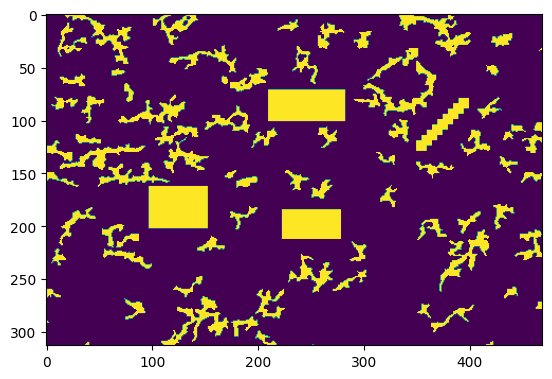

In [84]:
segmentation_clean = segmentation_map.copy()
for i in range(1, np.max(filaments)):
    tmp = segmentation_map.copy()
    tmp[filaments == i] = 0
    mssim_2 = structural_similarity(tmp,
                                                normed_image, 
                                                gaussian_weights=True,
                                                use_sample_covariance=False,
                                                sigma=sigma,
                                                K1 = K1,
                                                K2 = K1,
                                                data_range=data_range)
    if mssim_2 > mssim:
        segmentation_clean[filaments == i] = 0
filaments = morpho.label(segmentation_clean, connectivity=2)
plt.imshow(segmentation_clean)
print("Image where we removed decreasing MSSIM:", structural_similarity(segmentation_clean,
                                                normed_image, 
                                                gaussian_weights=True,
                                                use_sample_covariance=False,
                                                sigma=sigma,
                                                K1 = K1,
                                                K2 = K1,
                                                data_range=data_range))
fits.writeto("../../data_exploration/data/SEDIGISM/16/NH2_16_segmentation_labels.fits", data=filaments, header=header, overwrite=True)

In practice, we can see that no structure got remove, meaning they all individually improve the MSSIM so they are relevant to the filament segmentation, which is obviouslt wrong for the noise added.

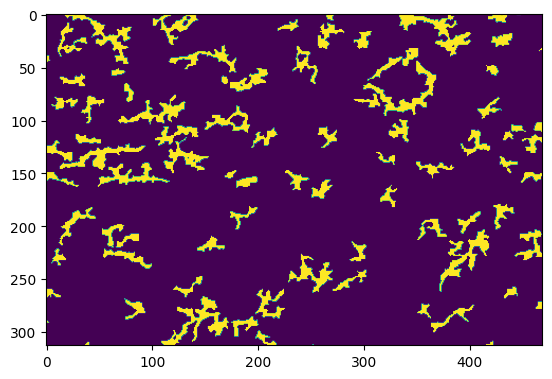

In [100]:
plt.imshow(segmentation_map)

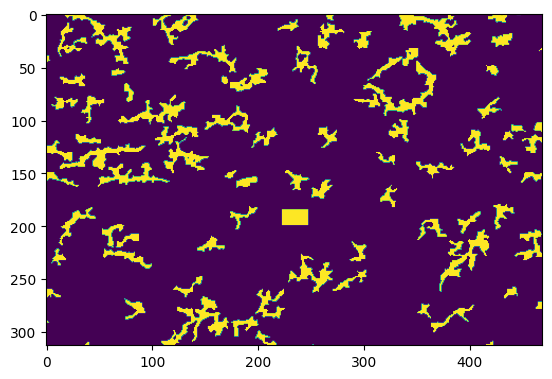

In [101]:
modified_img = segmentation_map.copy()
modified_img[185 : 185 + 15, 223 : 233 + 15] = 1

plt.imshow(modified_img)

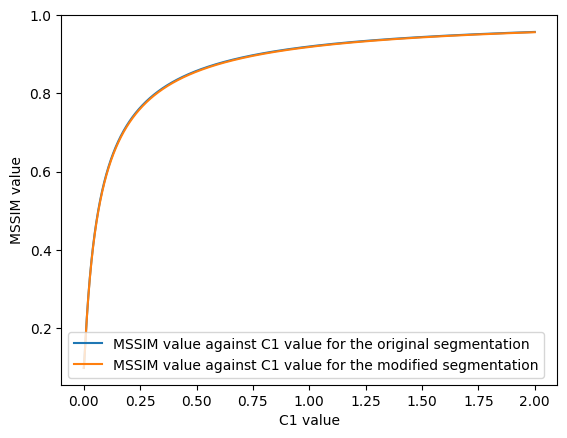

In [103]:
C1_list = np.linspace(0,2,20000)
MSSIM_list_original = np.zeros_like(C1_list)
MSSIM_list_modified = np.zeros_like(C1_list)
sigma = 5
data_range = 1

for i in range(len(C1_list)):
    MSSIM_list_original[i] = structural_similarity(segmentation_map,
                            normed_image,
                            gaussian_weights=True,
                            use_sample_covariance=False,
                            sigma=sigma,
                            K1 = np.sqrt(C1_list[i]),
                            K2 = np.sqrt(C1_list[i]),
                            data_range=data_range)
    MSSIM_list_modified[i] = structural_similarity(modified_img,
                            normed_image,
                            gaussian_weights=True,
                            use_sample_covariance=False,
                            sigma=sigma,
                            K1 = np.sqrt(C1_list[i]),
                            K2 = np.sqrt(C1_list[i]),
                            data_range=data_range)
    
plt.plot(C1_list, MSSIM_list_original, label="MSSIM value against C1 value for the original segmentation")
plt.plot(C1_list, MSSIM_list_modified, label="MSSIM value against C1 value for the modified segmentation")
plt.xlabel("C1 value")
plt.ylabel("MSSIM value")
plt.legend()
plt.show()

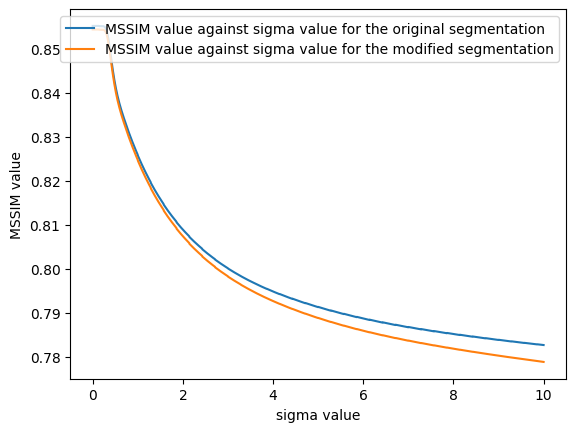

In [106]:
sigma_list = np.linspace(0,10,2000)
MSSIM_list_original = np.zeros_like(sigma_list)
MSSIM_list_modified = np.zeros_like(sigma_list)
sigma = 5
data_range = 1
C1 = 0.3
K1 = np.sqrt(C1/data_range)

for i in range(len(sigma_list)):
    MSSIM_list_original[i] = structural_similarity(segmentation_map,
                            normed_image,
                            gaussian_weights=True,
                            use_sample_covariance=False,
                            sigma=sigma_list[i],
                            K1 = K1,
                            K2 = K1,
                            data_range=data_range)
    MSSIM_list_modified[i] = structural_similarity(modified_img,
                            normed_image,
                            gaussian_weights=True,
                            use_sample_covariance=False,
                            sigma=sigma_list[i],
                            K1 = K1,
                            K2 = K1,
                            data_range=data_range)
    
plt.plot(sigma_list, MSSIM_list_original, label="MSSIM value against sigma value for the original segmentation")
plt.plot(sigma_list, MSSIM_list_modified, label="MSSIM value against sigma value for the modified segmentation")
plt.xlabel("sigma value")
plt.ylabel("MSSIM value")
plt.legend()
plt.show()

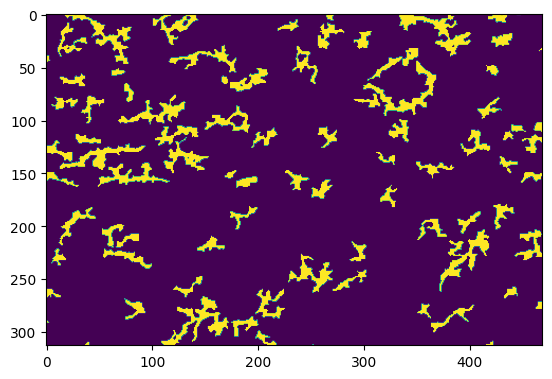

In [3]:
plt.imshow(segmentation_map)
original_MSSIM = structural_similarity(segmentation_map,
                        normed_image, 
                        gaussian_weights=True,
                        use_sample_covariance=False,
                        sigma=sigma,
                        K1 = K1,
                        K2 = K1,
                        data_range=data_range)

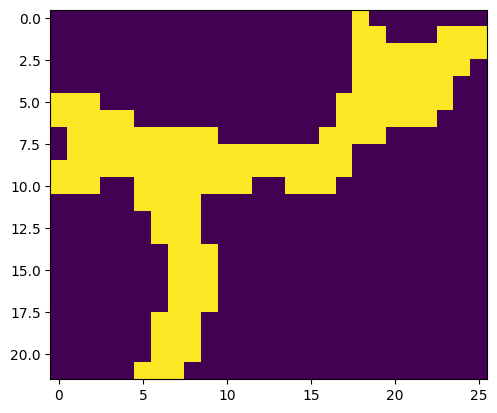

In [4]:
plt.imshow(segmentation_map[182:204,174:200])

Modified image with worst MSSIM than original segmentation: True


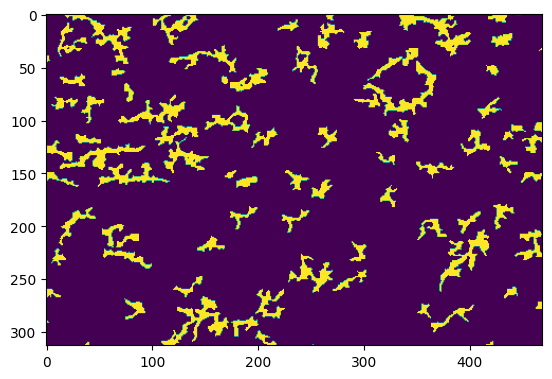

In [5]:
segmentation_map_modified = segmentation_map.copy()
segmentation_map_modified[185 : 185 + 22, 223 : 223 + 26] = segmentation_map[182:204,174:200]
plt.imshow(segmentation_map_modified)
print("Modified image with worst MSSIM than original segmentation:", structural_similarity(segmentation_map_modified,
                        normed_image, 
                        gaussian_weights=True,
                        use_sample_covariance=False,
                        sigma=sigma,
                        K1 = K1,
                        K2 = K1,
                        data_range=data_range) < original_MSSIM)

Modified image with worst MSSIM than original segmentation: False


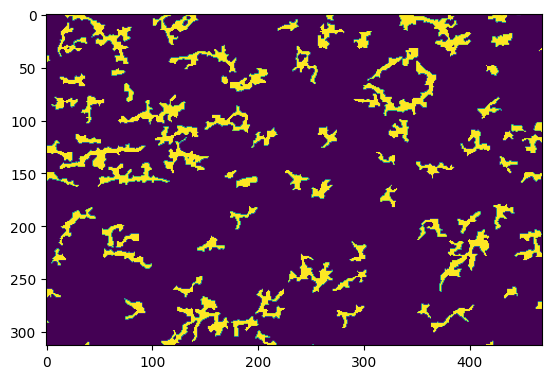

In [6]:
segmentation_map_modified = segmentation_map.copy()
segmentation_map_modified[275 : 275 + 22, 275 : 275 + 26] = segmentation_map[182:204,174:200]
plt.imshow(segmentation_map_modified)
print("Modified image with worst MSSIM than original segmentation:", structural_similarity(segmentation_map_modified,
                        normed_image, 
                        gaussian_weights=True,
                        use_sample_covariance=False,
                        sigma=sigma,
                        K1 = K1,
                        K2 = K1,
                        data_range=data_range) < original_MSSIM)

Modified image with worst MSSIM than original segmentation: True


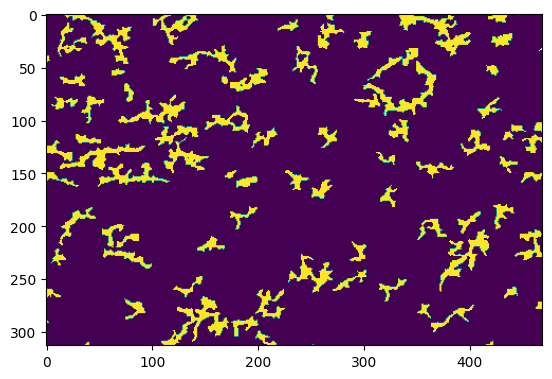

In [7]:
segmentation_map_modified = segmentation_map.copy()
segmentation_map_modified[250 : 250 + 22, 315 : 315 + 26] = segmentation_map[182:204,174:200]
plt.imshow(segmentation_map_modified)
print("Modified image with worst MSSIM than original segmentation:", structural_similarity(segmentation_map_modified,
                        normed_image, 
                        gaussian_weights=True,
                        use_sample_covariance=False,
                        sigma=sigma,
                        K1 = K1,
                        K2 = K1,
                        data_range=data_range) < original_MSSIM)

Modified image with worst MSSIM than original segmentation: True


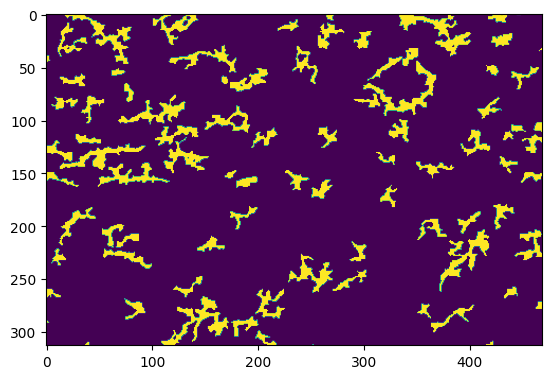

In [9]:
segmentation_map_modified = segmentation_map.copy()
segmentation_map_modified[50 : 50 + 22, 440 : 440 + 26] = segmentation_map[182:204,174:200]
plt.imshow(segmentation_map_modified)
print("Modified image with worst MSSIM than original segmentation:", structural_similarity(segmentation_map_modified,
                        normed_image, 
                        gaussian_weights=True,
                        use_sample_covariance=False,
                        sigma=sigma,
                        K1 = K1,
                        K2 = K1,
                        data_range=data_range) < original_MSSIM)

Modified image with worst MSSIM than original segmentation: True


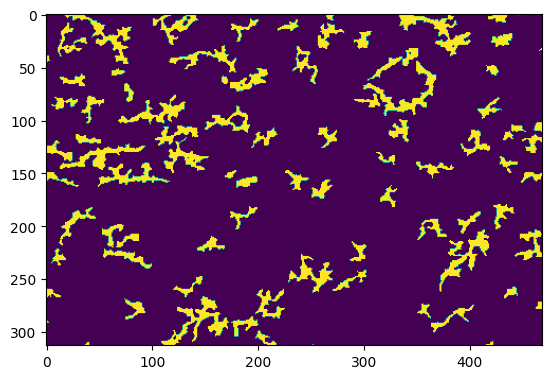

In [11]:
segmentation_map_modified = segmentation_map.copy()
segmentation_map_modified[5 : 5 + 22, 175 : 175 + 26] = segmentation_map[182:204,174:200]
plt.imshow(segmentation_map_modified)
print("Modified image with worst MSSIM than original segmentation:", structural_similarity(segmentation_map_modified,
                        normed_image, 
                        gaussian_weights=True,
                        use_sample_covariance=False,
                        sigma=sigma,
                        K1 = K1,
                        K2 = K1,
                        data_range=data_range) < original_MSSIM)

# MSSIM tests

(313, 469)
raw image MSSIM: 0.9260235153952692


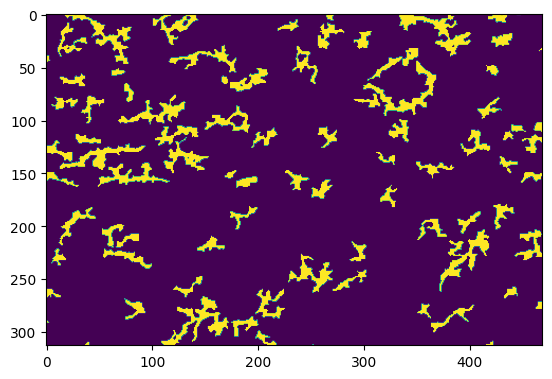

In [3]:
segmentation_file = "../../data_exploration/data/SEDIGISM/16/NH2_16_UNetPP.fits"
segmentation_map = fits.getdata(segmentation_file)
idx = np.isnan(segmentation_map)
segmentation_map[idx] = 0
header = fits.getheader(segmentation_file)
print(segmentation_map.shape)

normed_file = "../../data_exploration/data/SEDIGISM/16/NH2_16_normed.fits"
normed_image = fits.getdata(normed_file)
idx = np.isnan(normed_image)
normed_image[idx] = 0

sigma = 1.5
C1 = 1
data_range = 1

K1 = np.sqrt(C1 / data_range)

plt.imshow(segmentation_map)
print("raw image MSSIM:", structural_similarity(segmentation_map,
                                                normed_image, 
                                                gaussian_weights=True,
                                                use_sample_covariance=False,
                                                sigma=sigma,
                                                K1 = K1,
                                                K2 = K1,
                                                data_range=data_range))

In [4]:
filaments = morpho.label(segmentation_map, connectivity=2)

In [5]:
xmin = np.zeros(np.max(filaments) - 1)
xmax = np.zeros(np.max(filaments) - 1)
ymin = np.zeros(np.max(filaments) - 1)
ymax = np.zeros(np.max(filaments) - 1)
for k in range(1, np.max(filaments)):
    x = []
    y = []
    for i in range(filaments.shape[0]):
        for j in range(filaments.shape[1]):
            if filaments[i,j] == k:
                x.append(i)
                y.append(j)
    xmin[k - 1] = np.min(x)
    xmax[k - 1] = np.max(x) + 1
    ymin[k - 1] = np.min(y)
    ymax[k - 1] = np.max(y) + 1

0.0


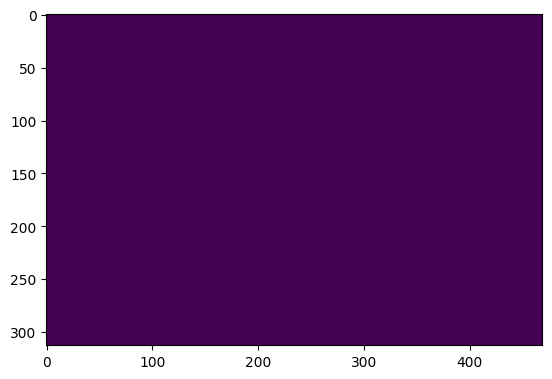

In [36]:
sigma = 1.5
C1 = 1
data_range = 1
K1 = np.sqrt(C1 / data_range)

count_1 = 0
count_2 = 0
overlap = 16
heat_map = np.zeros_like(segmentation_map)
for k in range(len(xmin)):
    full_mask = filaments.copy()
    full_mask[full_mask != k + 1] = 0
    mask = full_mask[int(xmin[k]) : int(xmax[k]), int(ymin[k]) : int(ymax[k])]
    x_size = int(xmax[k] - xmin[k])
    y_size = int(ymax[k] - ymin[k])
    for i in range(overlap, segmentation_map.shape[0] - overlap):
        for j in range(overlap, segmentation_map.shape[1] - overlap):
            if j + y_size <= segmentation_map.shape[1] and i + x_size <= segmentation_map.shape[0] and segmentation_map[i - 1 : i + x_size + 1, j - 1 : j + y_size + 1].sum() == 0:
                tmp = segmentation_map.copy()
                tmp[i : i + x_size, j : j + y_size] = mask
                tmp_mssim = structural_similarity(tmp[i - overlap : i + x_size + overlap, j - overlap : j + y_size + overlap],
                                        normed_image[i - overlap : i + x_size + overlap, j - overlap : j + y_size + overlap], 
                                        gaussian_weights=True,
                                        use_sample_covariance=False,
                                        sigma=sigma,
                                        K1 = K1,
                                        K2 = K1,
                                        data_range=data_range)
                original_mssim = structural_similarity(segmentation_map[i - overlap : i + x_size + overlap, j - overlap : j + y_size + overlap],
                                        normed_image[i - overlap : i + x_size + overlap, j - overlap : j + y_size + overlap], 
                                        gaussian_weights=True,
                                        use_sample_covariance=False,
                                        sigma=sigma,
                                        K1 = K1,
                                        K2 = K1,
                                        data_range=data_range)
                count_1 += 1
                if tmp_mssim > original_mssim:
                    count_2 += 1
                    heat_map[i : i + x_size, j : j + y_size] += mask
print(count_2 / count_1)
plt.imshow(heat_map)

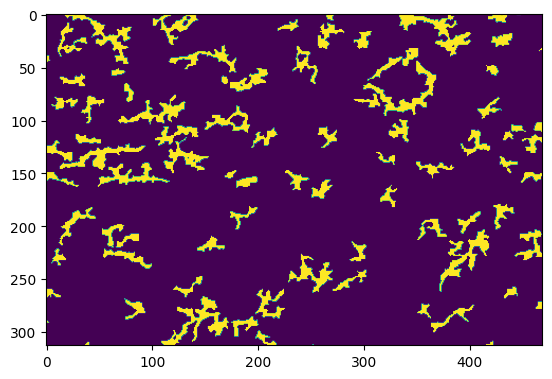

In [38]:
heat_map[heat_map > 0] = 1
plt.imshow(heat_map + segmentation_map)

0.0


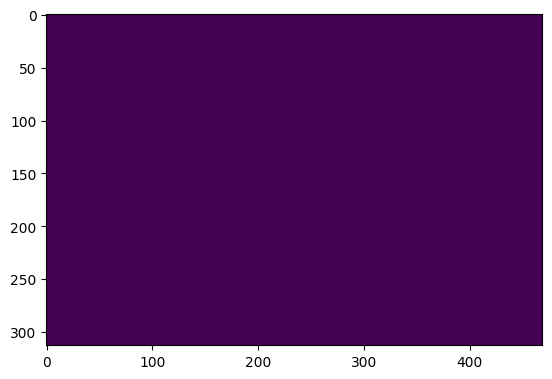

In [37]:
sigma = 1.5
C1 = 0.1
data_range = 1
K1 = np.sqrt(C1 / data_range)

count_1 = 0
count_2 = 0
overlap = 16
heat_map = np.zeros_like(segmentation_map)
for k in range(len(xmin)):
    full_mask = filaments.copy()
    full_mask[full_mask != k + 1] = 0
    mask = full_mask[int(xmin[k]) : int(xmax[k]), int(ymin[k]) : int(ymax[k])]
    x_size = int(xmax[k] - xmin[k])
    y_size = int(ymax[k] - ymin[k])
    for i in range(overlap, segmentation_map.shape[0] - overlap):
        for j in range(overlap, segmentation_map.shape[1] - overlap):
            if j + y_size <= segmentation_map.shape[1] and i + x_size <= segmentation_map.shape[0] and segmentation_map[i - 1 : i + x_size + 1, j - 1 : j + y_size + 1].sum() == 0:
                tmp = segmentation_map.copy()
                tmp[i : i + x_size, j : j + y_size] = mask
                tmp_mssim = structural_similarity(tmp[i - overlap : i + x_size + overlap, j - overlap : j + y_size + overlap],
                                        normed_image[i - overlap : i + x_size + overlap, j - overlap : j + y_size + overlap], 
                                        gaussian_weights=True,
                                        use_sample_covariance=False,
                                        sigma=sigma,
                                        K1 = K1,
                                        K2 = K1,
                                        data_range=data_range)
                original_mssim = structural_similarity(segmentation_map[i - overlap : i + x_size + overlap, j - overlap : j + y_size + overlap],
                                        normed_image[i - overlap : i + x_size + overlap, j - overlap : j + y_size + overlap], 
                                        gaussian_weights=True,
                                        use_sample_covariance=False,
                                        sigma=sigma,
                                        K1 = K1,
                                        K2 = K1,
                                        data_range=data_range)
                count_1 += 1
                if tmp_mssim > original_mssim:
                    count_2 += 1
                    heat_map[i : i + x_size, j : j + y_size] += mask
print(count_2 / count_1)
plt.imshow(heat_map)

0.0


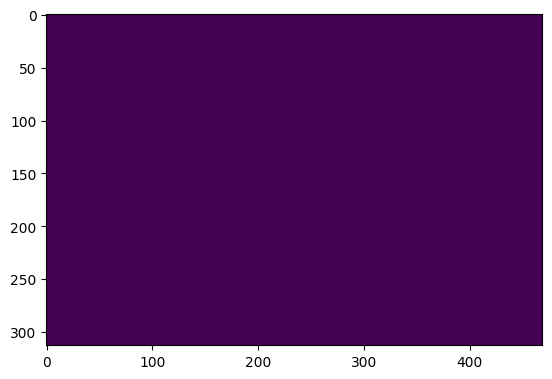

In [39]:
sigma = 1.5
C1 = 0.01
data_range = 1
K1 = np.sqrt(C1 / data_range)

count_1 = 0
count_2 = 0
overlap = 16
heat_map = np.zeros_like(segmentation_map)
for k in range(len(xmin)):
    full_mask = filaments.copy()
    full_mask[full_mask != k + 1] = 0
    mask = full_mask[int(xmin[k]) : int(xmax[k]), int(ymin[k]) : int(ymax[k])]
    x_size = int(xmax[k] - xmin[k])
    y_size = int(ymax[k] - ymin[k])
    for i in range(overlap, segmentation_map.shape[0] - overlap):
        for j in range(overlap, segmentation_map.shape[1] - overlap):
            if j + y_size <= segmentation_map.shape[1] and i + x_size <= segmentation_map.shape[0] and segmentation_map[i - 1 : i + x_size + 1, j - 1 : j + y_size + 1].sum() == 0:
                tmp = segmentation_map.copy()
                tmp[i : i + x_size, j : j + y_size] = mask
                tmp_mssim = structural_similarity(tmp[i - overlap : i + x_size + overlap, j - overlap : j + y_size + overlap],
                                        normed_image[i - overlap : i + x_size + overlap, j - overlap : j + y_size + overlap], 
                                        gaussian_weights=True,
                                        use_sample_covariance=False,
                                        sigma=sigma,
                                        K1 = K1,
                                        K2 = K1,
                                        data_range=data_range)
                original_mssim = structural_similarity(segmentation_map[i - overlap : i + x_size + overlap, j - overlap : j + y_size + overlap],
                                        normed_image[i - overlap : i + x_size + overlap, j - overlap : j + y_size + overlap], 
                                        gaussian_weights=True,
                                        use_sample_covariance=False,
                                        sigma=sigma,
                                        K1 = K1,
                                        K2 = K1,
                                        data_range=data_range)
                count_1 += 1
                if tmp_mssim > original_mssim:
                    count_2 += 1
                    heat_map[i : i + x_size, j : j + y_size] += mask
print(count_2 / count_1)
plt.imshow(heat_map)

0.004225481081672286


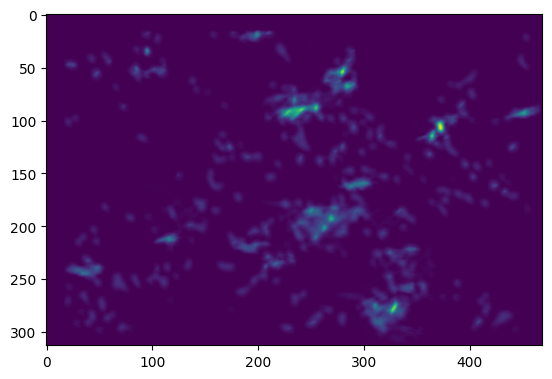

In [40]:
sigma = 1.5
C1 = 0.001
data_range = 1
K1 = np.sqrt(C1 / data_range)

count_1 = 0
count_2 = 0
overlap = 16
heat_map = np.zeros_like(segmentation_map)
for k in range(len(xmin)):
    full_mask = filaments.copy()
    full_mask[full_mask != k + 1] = 0
    mask = full_mask[int(xmin[k]) : int(xmax[k]), int(ymin[k]) : int(ymax[k])]
    x_size = int(xmax[k] - xmin[k])
    y_size = int(ymax[k] - ymin[k])
    for i in range(overlap, segmentation_map.shape[0] - overlap):
        for j in range(overlap, segmentation_map.shape[1] - overlap):
            if j + y_size <= segmentation_map.shape[1] and i + x_size <= segmentation_map.shape[0] and segmentation_map[i - 1 : i + x_size + 1, j - 1 : j + y_size + 1].sum() == 0:
                tmp = segmentation_map.copy()
                tmp[i : i + x_size, j : j + y_size] = mask
                tmp_mssim = structural_similarity(tmp[i - overlap : i + x_size + overlap, j - overlap : j + y_size + overlap],
                                        normed_image[i - overlap : i + x_size + overlap, j - overlap : j + y_size + overlap], 
                                        gaussian_weights=True,
                                        use_sample_covariance=False,
                                        sigma=sigma,
                                        K1 = K1,
                                        K2 = K1,
                                        data_range=data_range)
                original_mssim = structural_similarity(segmentation_map[i - overlap : i + x_size + overlap, j - overlap : j + y_size + overlap],
                                        normed_image[i - overlap : i + x_size + overlap, j - overlap : j + y_size + overlap], 
                                        gaussian_weights=True,
                                        use_sample_covariance=False,
                                        sigma=sigma,
                                        K1 = K1,
                                        K2 = K1,
                                        data_range=data_range)
                count_1 += 1
                if tmp_mssim > original_mssim:
                    count_2 += 1
                    heat_map[i : i + x_size, j : j + y_size] += mask
print(count_2 / count_1)
plt.imshow(heat_map)

0.15770137644489832


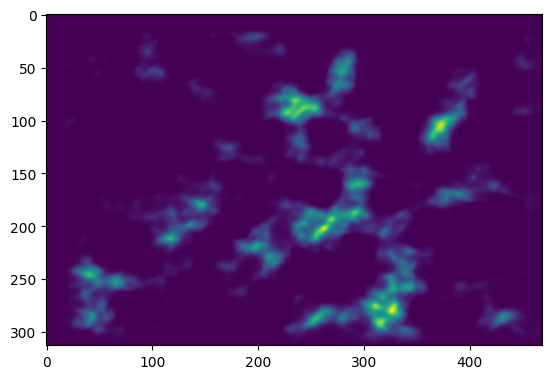

In [41]:
sigma = 1.5
C1 = 0.0001
data_range = 1
K1 = np.sqrt(C1 / data_range)

count_1 = 0
count_2 = 0
overlap = 16
heat_map = np.zeros_like(segmentation_map)
for k in range(len(xmin)):
    full_mask = filaments.copy()
    full_mask[full_mask != k + 1] = 0
    mask = full_mask[int(xmin[k]) : int(xmax[k]), int(ymin[k]) : int(ymax[k])]
    x_size = int(xmax[k] - xmin[k])
    y_size = int(ymax[k] - ymin[k])
    for i in range(overlap, segmentation_map.shape[0] - overlap):
        for j in range(overlap, segmentation_map.shape[1] - overlap):
            if j + y_size <= segmentation_map.shape[1] and i + x_size <= segmentation_map.shape[0] and segmentation_map[i - 1 : i + x_size + 1, j - 1 : j + y_size + 1].sum() == 0:
                tmp = segmentation_map.copy()
                tmp[i : i + x_size, j : j + y_size] = mask
                tmp_mssim = structural_similarity(tmp[i - overlap : i + x_size + overlap, j - overlap : j + y_size + overlap],
                                        normed_image[i - overlap : i + x_size + overlap, j - overlap : j + y_size + overlap], 
                                        gaussian_weights=True,
                                        use_sample_covariance=False,
                                        sigma=sigma,
                                        K1 = K1,
                                        K2 = K1,
                                        data_range=data_range)
                original_mssim = structural_similarity(segmentation_map[i - overlap : i + x_size + overlap, j - overlap : j + y_size + overlap],
                                        normed_image[i - overlap : i + x_size + overlap, j - overlap : j + y_size + overlap], 
                                        gaussian_weights=True,
                                        use_sample_covariance=False,
                                        sigma=sigma,
                                        K1 = K1,
                                        K2 = K1,
                                        data_range=data_range)
                count_1 += 1
                if tmp_mssim > original_mssim:
                    count_2 += 1
                    heat_map[i : i + x_size, j : j + y_size] += mask
print(count_2 / count_1)
plt.imshow(heat_map)

0.0


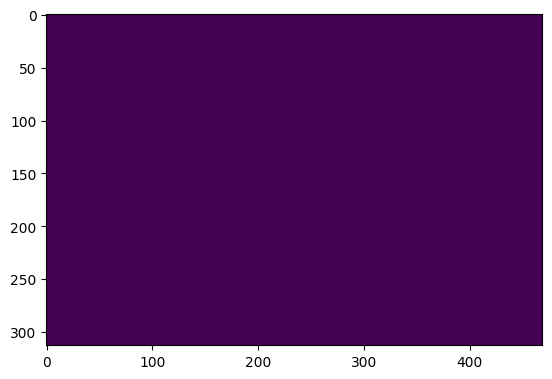

In [43]:
sigma = 2.5
C1 = 0.01
data_range = 1
K1 = np.sqrt(C1 / data_range)

count_1 = 0
count_2 = 0
overlap = 16
heat_map = np.zeros_like(segmentation_map)
for k in range(len(xmin)):
    full_mask = filaments.copy()
    full_mask[full_mask != k + 1] = 0
    mask = full_mask[int(xmin[k]) : int(xmax[k]), int(ymin[k]) : int(ymax[k])]
    x_size = int(xmax[k] - xmin[k])
    y_size = int(ymax[k] - ymin[k])
    for i in range(overlap, segmentation_map.shape[0] - overlap):
        for j in range(overlap, segmentation_map.shape[1] - overlap):
            if j + y_size <= segmentation_map.shape[1] and i + x_size <= segmentation_map.shape[0] and segmentation_map[i - 1 : i + x_size + 1, j - 1 : j + y_size + 1].sum() == 0:
                tmp = segmentation_map.copy()
                tmp[i : i + x_size, j : j + y_size] = mask
                tmp_mssim = structural_similarity(tmp[i - overlap : i + x_size + overlap, j - overlap : j + y_size + overlap],
                                        normed_image[i - overlap : i + x_size + overlap, j - overlap : j + y_size + overlap], 
                                        gaussian_weights=True,
                                        use_sample_covariance=False,
                                        sigma=sigma,
                                        K1 = K1,
                                        K2 = K1,
                                        data_range=data_range)
                original_mssim = structural_similarity(segmentation_map[i - overlap : i + x_size + overlap, j - overlap : j + y_size + overlap],
                                        normed_image[i - overlap : i + x_size + overlap, j - overlap : j + y_size + overlap], 
                                        gaussian_weights=True,
                                        use_sample_covariance=False,
                                        sigma=sigma,
                                        K1 = K1,
                                        K2 = K1,
                                        data_range=data_range)
                count_1 += 1
                if tmp_mssim > original_mssim:
                    count_2 += 1
                    heat_map[i : i + x_size, j : j + y_size] += mask
print(count_2 / count_1)
plt.imshow(heat_map)

0.2888429494557428


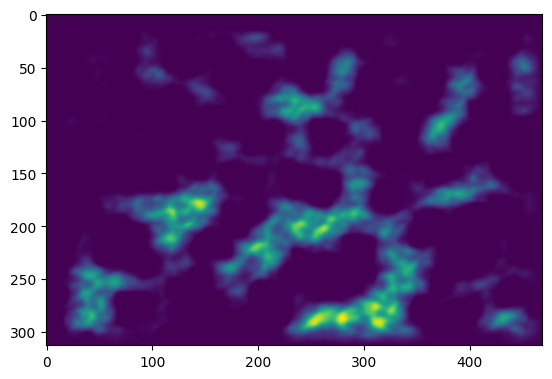

In [5]:
sigma = 1.5
C1 = 0.00001
data_range = 1
K1 = np.sqrt(C1 / data_range)

count_1 = 0
count_2 = 0
overlap = 16
heat_map = np.zeros_like(segmentation_map)
for k in range(len(xmin)):
    full_mask = filaments.copy()
    full_mask[full_mask != k + 1] = 0
    mask = full_mask[int(xmin[k]) : int(xmax[k]), int(ymin[k]) : int(ymax[k])]
    x_size = int(xmax[k] - xmin[k])
    y_size = int(ymax[k] - ymin[k])
    for i in range(overlap, segmentation_map.shape[0] - overlap):
        for j in range(overlap, segmentation_map.shape[1] - overlap):
            if j + y_size <= segmentation_map.shape[1] and i + x_size <= segmentation_map.shape[0] and segmentation_map[i - 1 : i + x_size + 1, j - 1 : j + y_size + 1].sum() == 0:
                tmp = segmentation_map.copy()
                tmp[i : i + x_size, j : j + y_size] = mask
                tmp_mssim = structural_similarity(tmp[i - overlap : i + x_size + overlap, j - overlap : j + y_size + overlap],
                                        normed_image[i - overlap : i + x_size + overlap, j - overlap : j + y_size + overlap], 
                                        gaussian_weights=True,
                                        use_sample_covariance=False,
                                        sigma=sigma,
                                        K1 = K1,
                                        K2 = K1,
                                        data_range=data_range)
                original_mssim = structural_similarity(segmentation_map[i - overlap : i + x_size + overlap, j - overlap : j + y_size + overlap],
                                        normed_image[i - overlap : i + x_size + overlap, j - overlap : j + y_size + overlap], 
                                        gaussian_weights=True,
                                        use_sample_covariance=False,
                                        sigma=sigma,
                                        K1 = K1,
                                        K2 = K1,
                                        data_range=data_range)
                count_1 += 1
                if tmp_mssim > original_mssim:
                    count_2 += 1
                    heat_map[i : i + x_size, j : j + y_size] += mask
print(count_2 / count_1)
plt.imshow(heat_map)

6.962982369347108e-05


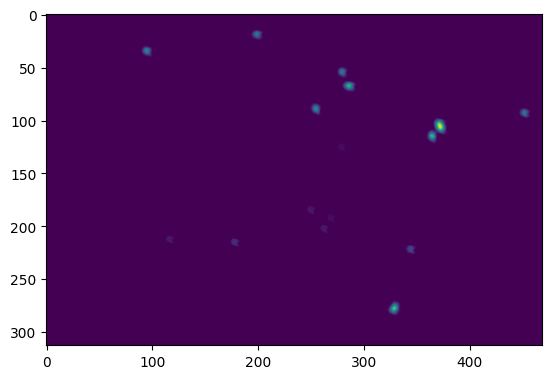

In [44]:
sigma = 3.5
C1 = 0.01
data_range = 1
K1 = np.sqrt(C1 / data_range)

count_1 = 0
count_2 = 0
overlap = 16
heat_map = np.zeros_like(segmentation_map)
for k in range(len(xmin)):
    full_mask = filaments.copy()
    full_mask[full_mask != k + 1] = 0
    mask = full_mask[int(xmin[k]) : int(xmax[k]), int(ymin[k]) : int(ymax[k])]
    x_size = int(xmax[k] - xmin[k])
    y_size = int(ymax[k] - ymin[k])
    for i in range(overlap, segmentation_map.shape[0] - overlap):
        for j in range(overlap, segmentation_map.shape[1] - overlap):
            if j + y_size <= segmentation_map.shape[1] and i + x_size <= segmentation_map.shape[0] and segmentation_map[i - 1 : i + x_size + 1, j - 1 : j + y_size + 1].sum() == 0:
                tmp = segmentation_map.copy()
                tmp[i : i + x_size, j : j + y_size] = mask
                tmp_mssim = structural_similarity(tmp[i - overlap : i + x_size + overlap, j - overlap : j + y_size + overlap],
                                        normed_image[i - overlap : i + x_size + overlap, j - overlap : j + y_size + overlap], 
                                        gaussian_weights=True,
                                        use_sample_covariance=False,
                                        sigma=sigma,
                                        K1 = K1,
                                        K2 = K1,
                                        data_range=data_range)
                original_mssim = structural_similarity(segmentation_map[i - overlap : i + x_size + overlap, j - overlap : j + y_size + overlap],
                                        normed_image[i - overlap : i + x_size + overlap, j - overlap : j + y_size + overlap], 
                                        gaussian_weights=True,
                                        use_sample_covariance=False,
                                        sigma=sigma,
                                        K1 = K1,
                                        K2 = K1,
                                        data_range=data_range)
                count_1 += 1
                if tmp_mssim > original_mssim:
                    count_2 += 1
                    heat_map[i : i + x_size, j : j + y_size] += mask
print(count_2 / count_1)
plt.imshow(heat_map)

In [45]:
sigma = 5
C1 = 0.01
data_range = 1
K1 = np.sqrt(C1 / data_range)

count_1 = 0
count_2 = 0
overlap = 16
heat_map = np.zeros_like(segmentation_map)
for k in range(len(xmin)):
    full_mask = filaments.copy()
    full_mask[full_mask != k + 1] = 0
    mask = full_mask[int(xmin[k]) : int(xmax[k]), int(ymin[k]) : int(ymax[k])]
    x_size = int(xmax[k] - xmin[k])
    y_size = int(ymax[k] - ymin[k])
    for i in range(overlap, segmentation_map.shape[0] - overlap):
        for j in range(overlap, segmentation_map.shape[1] - overlap):
            if j + y_size <= segmentation_map.shape[1] and i + x_size <= segmentation_map.shape[0] and segmentation_map[i - 1 : i + x_size + 1, j - 1 : j + y_size + 1].sum() == 0:
                tmp = segmentation_map.copy()
                tmp[i : i + x_size, j : j + y_size] = mask
                tmp_mssim = structural_similarity(tmp[i - overlap : i + x_size + overlap, j - overlap : j + y_size + overlap],
                                        normed_image[i - overlap : i + x_size + overlap, j - overlap : j + y_size + overlap], 
                                        gaussian_weights=True,
                                        use_sample_covariance=False,
                                        sigma=sigma,
                                        K1 = K1,
                                        K2 = K1,
                                        data_range=data_range)
                original_mssim = structural_similarity(segmentation_map[i - overlap : i + x_size + overlap, j - overlap : j + y_size + overlap],
                                        normed_image[i - overlap : i + x_size + overlap, j - overlap : j + y_size + overlap], 
                                        gaussian_weights=True,
                                        use_sample_covariance=False,
                                        sigma=sigma,
                                        K1 = K1,
                                        K2 = K1,
                                        data_range=data_range)
                count_1 += 1
                if tmp_mssim > original_mssim:
                    count_2 += 1
                    heat_map[i : i + x_size, j : j + y_size] += mask
print(count_2 / count_1)
plt.imshow(heat_map)

ValueError: win_size exceeds image extent. Either ensure that your images are at least 7x7; or pass win_size explicitly in the function call, with an odd value less than or equal to the smaller side of your images. If your images are multichannel (with color channels), set channel_axis to the axis number corresponding to the channels.

82


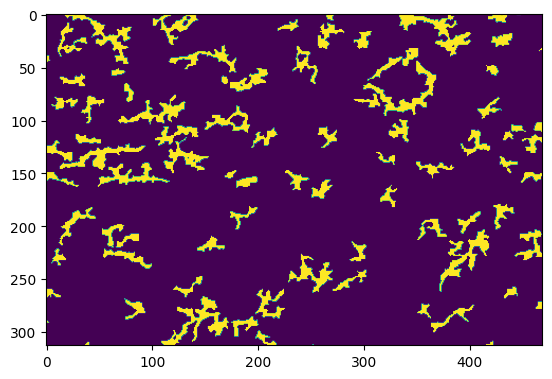

In [6]:
sigma = 1.5
C1 = 0
data_range = 1
K1 = 0

mssim = structural_similarity(segmentation_map,
                                normed_image, 
                                gaussian_weights=True,
                                use_sample_covariance=False,
                                sigma=sigma,
                                K1 = K1,
                                K2 = K1,
                                data_range=data_range)

segmentation_clean = segmentation_map.copy()

for i in range(1, np.max(filaments)):
    tmp = segmentation_map.copy()
    tmp[filaments == i] = 0
    mssim_2 = structural_similarity(tmp,
                                    normed_image, 
                                    gaussian_weights=True,
                                    use_sample_covariance=False,
                                    sigma=sigma,
                                    K1 = K1,
                                    K2 = K1,
                                    data_range=data_range)
    if mssim_2 > mssim:
        segmentation_clean[filaments == i] = 0
print(np.max(morpho.label(segmentation_clean, connectivity=2) - 1))
plt.imshow(segmentation_clean)

1


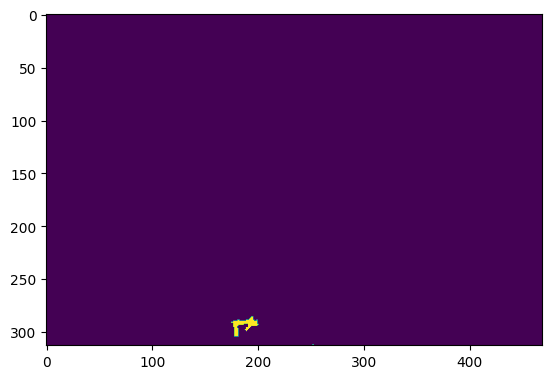

In [7]:
sigma = 1.5
C1 = 0.1
data_range = 1
K1 = np.sqrt(C1 / data_range)

mssim = structural_similarity(segmentation_map,
                                normed_image, 
                                gaussian_weights=True,
                                use_sample_covariance=False,
                                sigma=sigma,
                                K1 = K1,
                                K2 = K1,
                                data_range=data_range)

segmentation_clean = segmentation_map.copy()

for i in range(1, np.max(filaments)):
    tmp = segmentation_map.copy()
    tmp[filaments == i] = 0
    mssim_2 = structural_similarity(tmp,
                                    normed_image, 
                                    gaussian_weights=True,
                                    use_sample_covariance=False,
                                    sigma=sigma,
                                    K1 = K1,
                                    K2 = K1,
                                    data_range=data_range)
    if mssim_2 > mssim:
        segmentation_clean[filaments == i] = 0
print(np.max(morpho.label(segmentation_clean, connectivity=2) - 1))
plt.imshow(segmentation_clean)

81


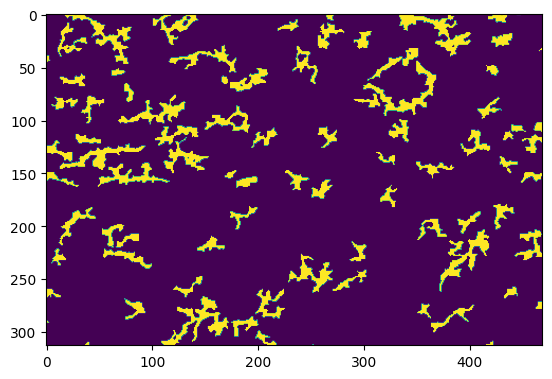

In [8]:
sigma = 1.5
C1 = 0
data_range = 1
K1 = np.sqrt(C1 / data_range)

mssim = structural_similarity(segmentation_map,
                                normed_image, 
                                gaussian_weights=True,
                                use_sample_covariance=False,
                                sigma=sigma,
                                K1 = K1,
                                K2 = K1,
                                data_range=data_range)

segmentation_clean = segmentation_map.copy()

for i in range(1, np.max(filaments)):
    tmp = segmentation_map.copy()
    tmp[filaments == i] = 0
    mssim_2 = structural_similarity(tmp,
                                    normed_image, 
                                    gaussian_weights=True,
                                    use_sample_covariance=False,
                                    sigma=sigma,
                                    K1 = K1,
                                    K2 = K1,
                                    data_range=data_range)
    if mssim_2 > mssim:
        segmentation_clean[filaments == i] = 0
print(np.max(morpho.label(segmentation_clean, connectivity=2) - 1))
plt.imshow(segmentation_clean)

82


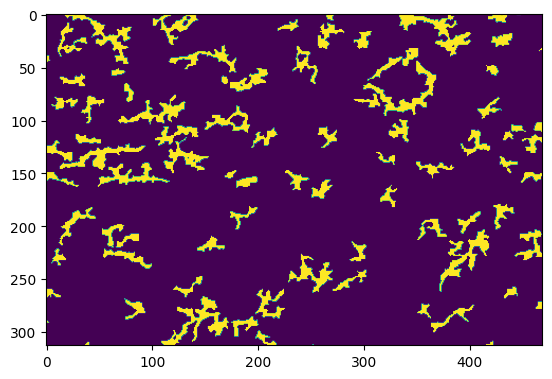

In [9]:
sigma = 1.5
C1 = 0.0001
data_range = 1
K1 = np.sqrt(C1 / data_range)

mssim = structural_similarity(segmentation_map,
                                normed_image, 
                                gaussian_weights=True,
                                use_sample_covariance=False,
                                sigma=sigma,
                                K1 = K1,
                                K2 = K1,
                                data_range=data_range)

segmentation_clean = segmentation_map.copy()

for i in range(1, np.max(filaments)):
    tmp = segmentation_map.copy()
    tmp[filaments == i] = 0
    mssim_2 = structural_similarity(tmp,
                                    normed_image, 
                                    gaussian_weights=True,
                                    use_sample_covariance=False,
                                    sigma=sigma,
                                    K1 = K1,
                                    K2 = K1,
                                    data_range=data_range)
    if mssim_2 > mssim:
        segmentation_clean[filaments == i] = 0
print(np.max(morpho.label(segmentation_clean, connectivity=2) - 1))
plt.imshow(segmentation_clean)

61


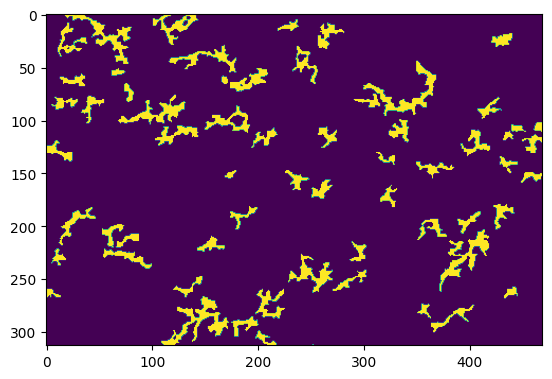

In [10]:
sigma = 2.5
C1 = 0.01
data_range = 1
K1 = np.sqrt(C1 / data_range)

mssim = structural_similarity(segmentation_map,
                                normed_image, 
                                gaussian_weights=True,
                                use_sample_covariance=False,
                                sigma=sigma,
                                K1 = K1,
                                K2 = K1,
                                data_range=data_range)

segmentation_clean = segmentation_map.copy()

for i in range(1, np.max(filaments)):
    tmp = segmentation_map.copy()
    tmp[filaments == i] = 0
    mssim_2 = structural_similarity(tmp,
                                    normed_image, 
                                    gaussian_weights=True,
                                    use_sample_covariance=False,
                                    sigma=sigma,
                                    K1 = K1,
                                    K2 = K1,
                                    data_range=data_range)
    if mssim_2 > mssim:
        segmentation_clean[filaments == i] = 0
print(np.max(morpho.label(segmentation_clean, connectivity=2) - 1))
plt.imshow(segmentation_clean)

68


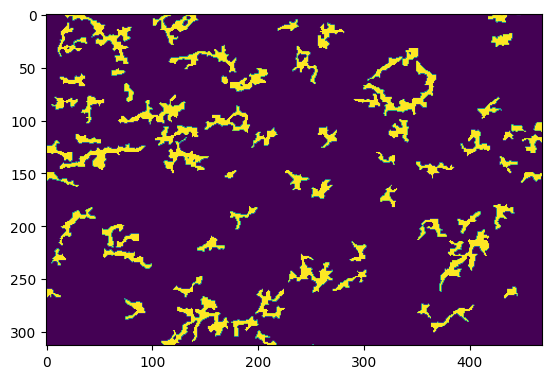

In [11]:
sigma = 3.5
C1 = 0.01
data_range = 1
K1 = np.sqrt(C1 / data_range)

mssim = structural_similarity(segmentation_map,
                                normed_image, 
                                gaussian_weights=True,
                                use_sample_covariance=False,
                                sigma=sigma,
                                K1 = K1,
                                K2 = K1,
                                data_range=data_range)

segmentation_clean = segmentation_map.copy()

for i in range(1, np.max(filaments)):
    tmp = segmentation_map.copy()
    tmp[filaments == i] = 0
    mssim_2 = structural_similarity(tmp,
                                    normed_image, 
                                    gaussian_weights=True,
                                    use_sample_covariance=False,
                                    sigma=sigma,
                                    K1 = K1,
                                    K2 = K1,
                                    data_range=data_range)
    if mssim_2 > mssim:
        segmentation_clean[filaments == i] = 0
print(np.max(morpho.label(segmentation_clean, connectivity=2) - 1))
plt.imshow(segmentation_clean)

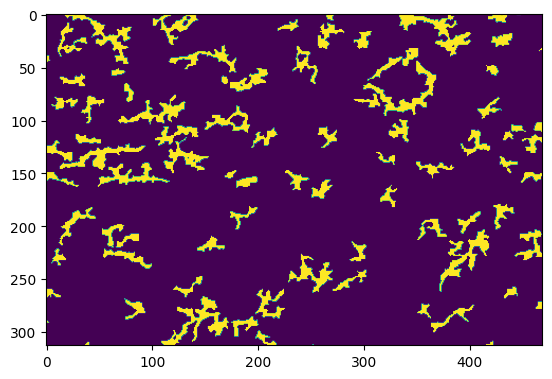

In [16]:
segmentation_file = "../../data_exploration/data/SEDIGISM/16/NH2_16_UNetPP.fits"
segmentation_map = fits.getdata(segmentation_file)
idx = np.isnan(segmentation_map)
segmentation_map[idx] = 0
header = fits.getheader(segmentation_file)

normed_file = "../../data_exploration/data/SEDIGISM/16/NH2_16_normed.fits"
normed_image = fits.getdata(normed_file)
idx = np.isnan(normed_image)
normed_image[idx] = 0

plt.imshow(segmentation_map)
plt.show()

count = np.zeros((len(C1), len(sigma)))
heat_map = np.zeros_like(segmentation_map)

filaments = morpho.label(segmentation_map, connectivity=2)

xmin = np.zeros(np.max(filaments) - 1)
xmax = np.zeros(np.max(filaments) - 1)
ymin = np.zeros(np.max(filaments) - 1)
ymax = np.zeros(np.max(filaments) - 1)

mssim_sup = np.zeros(np.max(filaments) - 1)
false_structure = np.zeros(np.max(filaments) - 1)
for k in range(1, np.max(filaments)):
    x = []
    y = []
    for i in range(filaments.shape[0]):
        for j in range(filaments.shape[1]):
            if filaments[i,j] == k:
                x.append(i)
                y.append(j)
    xmin[k - 1] = np.min(x)
    xmax[k - 1] = np.max(x) + 1
    ymin[k - 1] = np.min(y)
    ymax[k - 1] = np.max(y) + 1

In [ ]:
data_range = 1
C1 = np.array([0.001, 0.005, 0.01, 0.03, 0.07, 0.1, 0.3, 0.7, 1, 3])
sigma = np.linspace(1.5, 4.6, 8)
overlap = 16

for n in range(len(C1)):
    for m in range(len(sigma)):
        count_1 = 0
        count_2 = 0
        for k in range(len(xmin)):
            sub_count_1 = 0
            sub_count_2 = 0
            full_mask = filaments.copy()
            full_mask[full_mask != k + 1] = 0
            mask = full_mask[int(xmin[k]) : int(xmax[k]), int(ymin[k]) : int(ymax[k])]
            x_size = int(xmax[k] - xmin[k])
            y_size = int(ymax[k] - ymin[k])
            for i in range(overlap, segmentation_map.shape[0] - overlap):
                for j in range(overlap, segmentation_map.shape[1] - overlap):
                    if j + y_size <= segmentation_map.shape[1] and i + x_size <= segmentation_map.shape[0] and segmentation_map[i - 1 : i + x_size + 1, j - 1 : j + y_size + 1].sum() == 0:
                        tmp = segmentation_map.copy()
                        tmp[i : i + x_size, j : j + y_size] = mask
                        tmp_mssim = structural_similarity(tmp[i - overlap : i + x_size + overlap, j - overlap : j + y_size + overlap],
                                                normed_image[i - overlap : i + x_size + overlap, j - overlap : j + y_size + overlap], 
                                                gaussian_weights=True,
                                                use_sample_covariance=False,
                                                sigma=sigma[m],
                                                K1 = C1[n],
                                                K2 = C1[n],
                                                data_range=data_range)
                        original_mssim = structural_similarity(segmentation_map[i - overlap : i + x_size + overlap, j - overlap : j + y_size + overlap],
                                                normed_image[i - overlap : i + x_size + overlap, j - overlap : j + y_size + overlap], 
                                                gaussian_weights=True,
                                                use_sample_covariance=False,
                                                sigma=sigma[m],
                                                K1 = C1[n],
                                                K2 = C1[n],
                                                data_range=data_range)
                        sub_count_1 += 1
                        if tmp_mssim > original_mssim:
                            sub_count_2 += 1
                            heat_map[i : i + x_size, j : j + y_size] += mask
            mssim_sup[k] += sub_count_2
            false_structure[k] += sub_count_1
            count_1 += sub_count_1
            count_2 += sub_count_2
        count[n, m] = count_2 / count_1

plt.imshow(heat_map)
plt.show()

tmp = mssim_sup / false_structure
idx = np.argmax(tmp)
full_mask = filaments.copy()
full_mask[full_mask != idx + 1] = 0
plt.imshow(full_mask[int(xmin[idx]) : int(xmax[idx]), int(ymin[idx]) : int(ymax[idx])])
plt.title(f'{tmp[idx]}')
plt.legend()
plt.show()

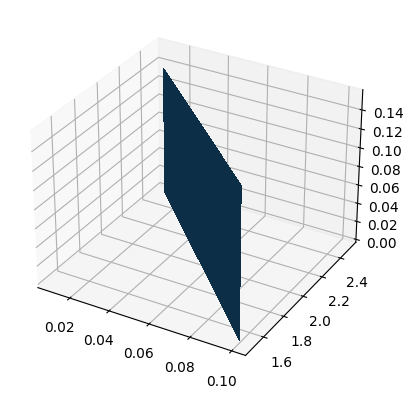

In [7]:
C1, sigma = np.meshgrid(C1, sigma)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(C1, sigma, count,
                       linewidth=0, antialiased=False)
ax.zaxis.set_major_formatter('{x:.02f}')
ax.set_xlabel("C1")
ax.set_ylabel("sigma")
ax.set_zlabel("Pourcentage of false filaments increasing MSSIM")
plt.show()